In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1189190723854475313
xla_global_id: -1
]


In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

### Convolution Layers

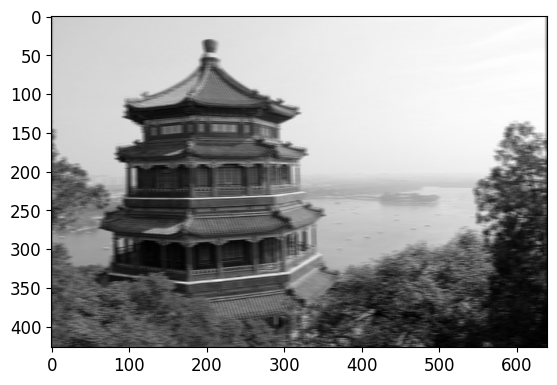

In [ ]:
from sklearn.datasets import load_sample_image
# (MANUALLY WRITING=====*************)

## we'll load sample images
china = load_sample_image("china.jpg")/255
flower = load_sample_image("flower.jpg")/255
images = np.array([china, flower ])
batch_size, height, width, channels = images.shape


#Create 2 filters (MANUALLY DEFINING IT)
filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)  # 7,7 is the kernel(filter) size
filters[:, 3, :, 0] = 1 ##vertical line
filters[3,:,:,1] = 1 ##horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding = "SAME") #"SAME" means zero padding 
#images = this is the input mini-batch
# strides  = it controls by how much the filter moves
#            if 1= filter moves by 1 


plt.imshow(outputs[0, :, :, 1], cmap="gray") ##plotting 1st image's 2nd feature  map
plt.show()

In [6]:
## Convolution : Extract features of the input 

## Pooling Layer : downsample the features of the convolutuion layer 

#A feature map is the output of applying a filter (kernel) over an input image or a previous feature map.
# The filter slides over the input, performs element-wise multiplication
# and summation (convolution), and produces a 2D matrix — that's the feature map.

# Refer pg 455 Diagram for the diff in padding="SAME"/"VALID"

In [ ]:
## In the above code we manually defined the filters
# Instread keras.layers.Conv2D
# (USING THE LIBRARY====================********)
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="SAME", activation="relu")

-->> In this image the Convolution layers consists of kernels that produce the feature map                       
--> the Pooling layer downscales the pixels to lowest resolution poss                                      
--> finally the Fully Connected layer identifies the number  taking i/p from the pooling layer                      

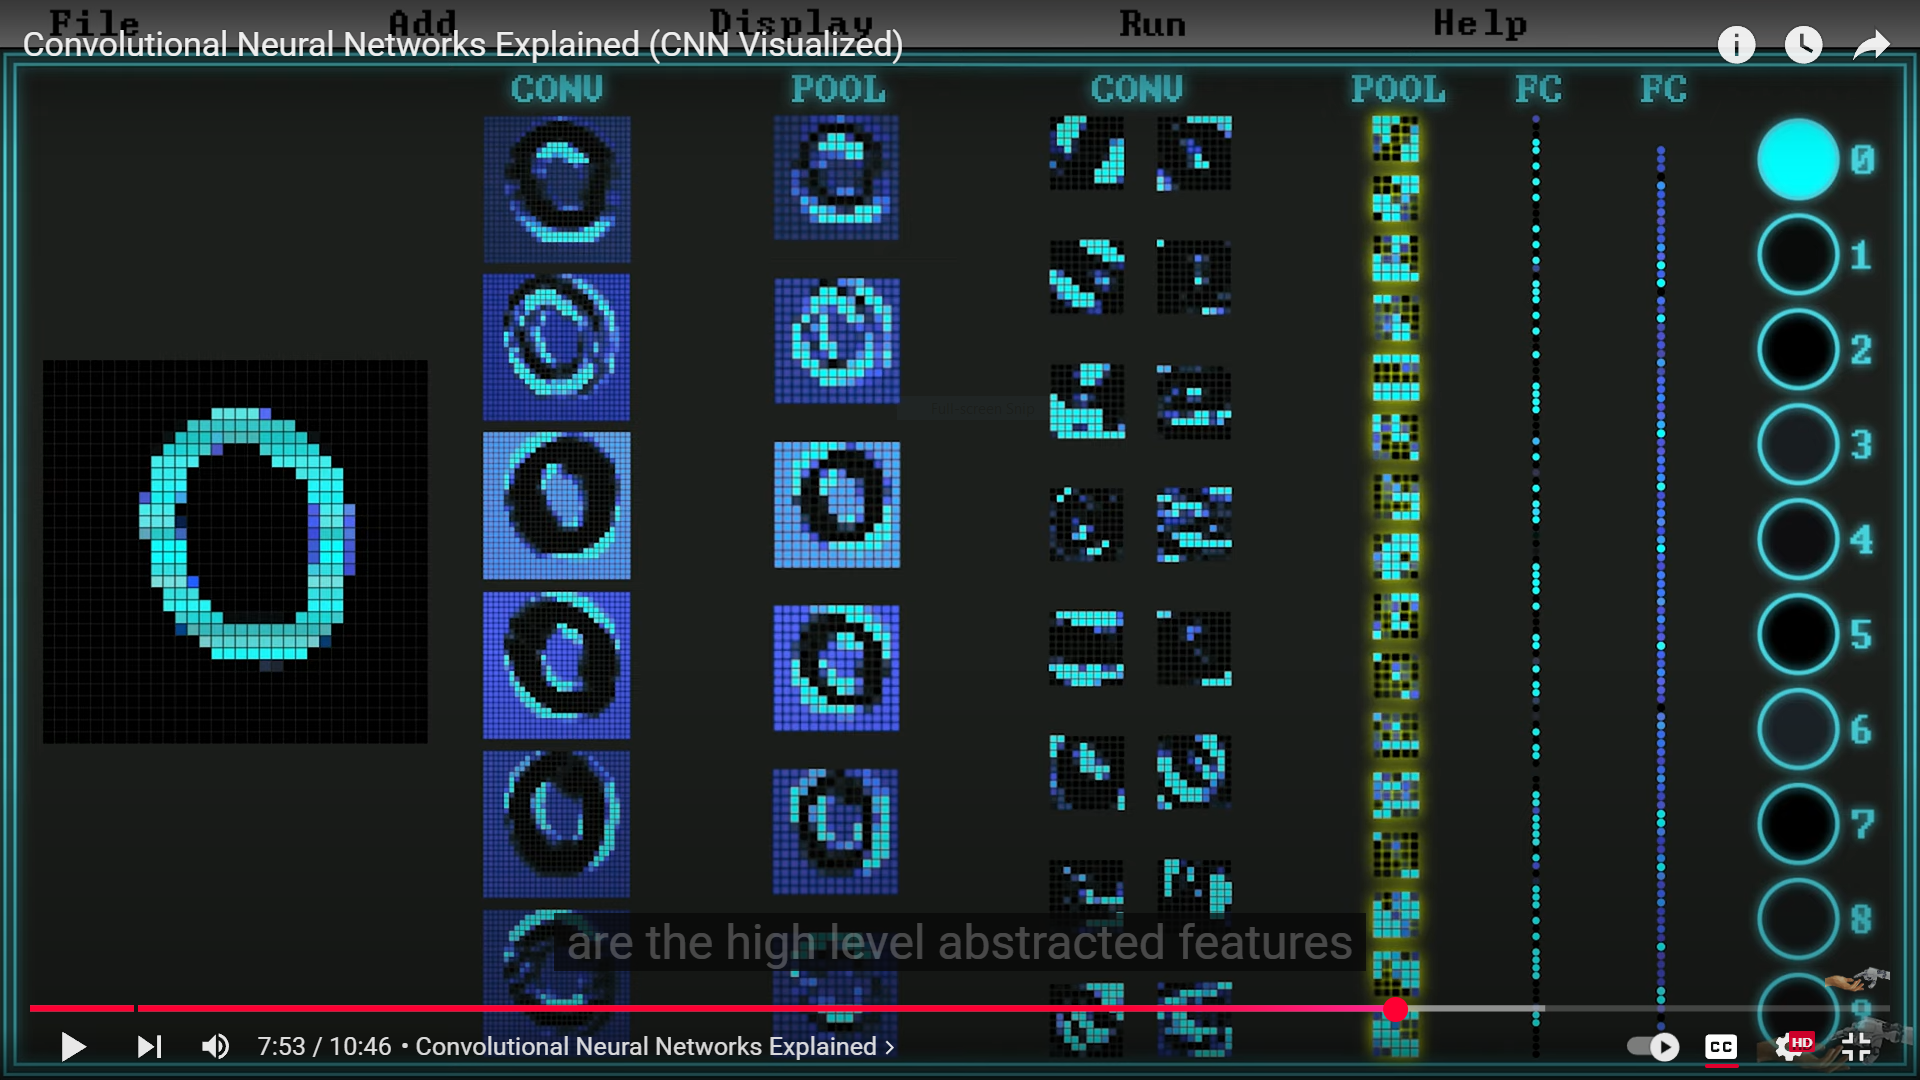

In [ ]:
## Why CNN req high RAM? 
# Backpropagation, Feature Maps, Also the Image res and sizes are super large


### Pooling Layers

In the pooling matrix , as the main work of the pooling layers is to reduce the resolution to make computation easy 
from that matrix only the highest value is propagated (Refer pg 457).

--> Translation Invariance : (Refer pg 458)

In [ ]:
## Tensorflow Code

# (STANDARD MAX Pooling)
max_pool = keras.layers.MaxPool2D(pool_size=2)

# say you feature map has 28x28x32 (32 channels/depth) & Pool is of 2x2
# Then in Standard Max Pooling it will be 14x14x32 (the depth/layers wont get reduced)

In [9]:
## Types: Averang & Max Pooling Layer
# Max: takes the max value from the matrix
# Average = takes the average of all the values in the matrix and propagates further

# In Max Pooling Layers : preserves only the strongest features discarding other meaningless ones

# DepthWise Max Pooling:
output = tf.nn.max_pool(images, ksize=(1,1,1,3),
                        strides=(1,1,1,3),
                        padding = "valid")
# say you feature map has 28x28x32 (32 channels/depth) & Pool is of 2x2
# Then in Standard Max Pooling it will be 14x14x16 (the depth/layers ALSO get reduced)



InvalidArgumentError: Value for attr 'padding' of "valid" is not in the list of allowed values: "SAME", "VALID", "EXPLICIT"
	; NodeDef: {{node MaxPool}}; Op<name=MaxPool; signature=input:T -> output:T; attr=T:type,default=DT_FLOAT,allowed=[DT_HALF, DT_BFLOAT16, DT_FLOAT, DT_DOUBLE, DT_INT32, DT_INT64, DT_UINT8, DT_INT16, DT_INT8, DT_UINT16, DT_QINT8]; attr=ksize:list(int),min=4; attr=strides:list(int),min=4; attr=padding:string,allowed=["SAME", "VALID", "EXPLICIT"]; attr=explicit_paddings:list(int),default=[]; attr=data_format:string,default="NHWC",allowed=["NHWC", "NCHW", "NCHW_VECT_C"]> [Op:MaxPool] name: 

In [ ]:
## To include DepthWise Pooling in Custom KERAS layer
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1,1,1,3), strides=(1,1,1,3),
                             padding = "valid")
)

In [ ]:
# Global Average Pooling Layer
# In this the Dimensions of Pooling Kernel = Dimensions of Input 
# Therefore it generates a single number per feature map
global_avg_pool = keras.layers.GlobalAvgPool2D()



# Building a CNN

### **Fashion MNIST DATASET**

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 27s 1us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


In [11]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding = "same", # 64 filters of 7x7 each
                        input_shape=[28,28,1]), # the input shape is 28x28 greyscale 1 channel
    keras.layers.MaxPooling2D(2), #reduces spatial size by /2
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"), # 128 filters 3x3 each
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation = "relu", padding = "same"),# Two layers stacked->learn more complex patterns
    keras.layers.Conv2D(256, 3, activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(), # Converts 3D feature maps to 1D features
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = "softmax")
])
# Pattern: 
# [Conv → Conv → Pool] → [Conv → Conv → Pool] → [Conv → Conv → Pool]

#The identical double layers are for higher level features 

#Depending on the complexity of the dataset you can choose the conv-pool blocks 


c:\Users\varad\Documents\Aurelien Geron\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:


model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)



Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 137s 77ms/step - accuracy: 0.7440 - loss: 0.7291 - val_accuracy: 0.8682 - val_loss: 0.3738
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 136s 79ms/step - accuracy: 0.8519 - loss: 0.4373 - val_accuracy: 0.8616 - val_loss: 0.3870
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 138s 80ms/step - accuracy: 0.8730 - loss: 0.3761 - val_accuracy: 0.8900 - val_loss: 0.3164
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 136s 79ms/step - accuracy: 0.8823 - loss: 0.3467 - val_accuracy: 0.8946 - val_loss: 0.2892
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 133s 77ms/step - accuracy: 0.8913 - loss: 0.3192 - val_accuracy: 0.8924 - val_loss: 0.2947
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 128s 75ms/step - accuracy: 0.8985 - loss: 0.3003 - val_accuracy: 0.8896 - val_loss: 0.3077
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 147s 86ms/step - accuracy: 0.9032 - loss: 0.2826 - val_accuracy: 0.8910 - val_loss: 0.2984
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 144s 83ms/step - accuracy: 

## Architecture Types 

### LeNet-5
-> Use of AvgPooling                          
-> The most Widely Known CNN Architecture Type                   
-> Widely used for handwritten digit recognition (MNIST)

### AlexNet
-> It was first to stach convolution layers on top of each other 
-> To reduce overfitting- applied droupout, second: they performed Data Augmentation (producing various forms of data)
-> In AlexNet the struct is *Convo->ReLU->LRN(Local Response Normalization)

### GoogLeNet
-> Use of Inception Module (Refer Pg 467 )
-> These Inception Modules act as bottleneck layers as they reduce dimensionality
-> Super deep architecture 

### VGG (Visual Geometry Group)
-> showed that very deep networks (16–19 layers) with small 3×3 filters can greatly improve accuracy.

### ResNet (Residual Network)
-> Next Gen version og VGG
-> Was an extremely deep CNN (152 layers)
-> The idea of skipping connections (Shortcut Connections) was used 
-> Residual Learning (Refer pg 471)
